# HCC Study

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats as stats
import torch
import networkx as nx
from metvae.model import MetVAE

import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [2]:
df_abundance = pd.read_csv('../data/hcc/hcc_abundance.csv', index_col=0)
smd = pd.read_csv('../data/hcc/hcc_smd.csv', index_col=0)
fmd = pd.read_table('../data/hcc/hcc_fmd.tsv')
fmd = fmd.set_index('#Scan#')
fmd.index = fmd.index.astype(str)

print('data shape:', df_abundance.shape)
print('sample metadata shape:', smd.shape)
print('feature metadata (MS2) shape:', fmd.shape)

data shape: (2122, 438)
sample metadata shape: (438, 53)
feature metadata (MS2) shape: (2122, 45)


### Outcomes of interest

In [3]:
smd['HCC'].value_counts()

HCC
False    235
True     203
Name: count, dtype: int64

### Potential covariates/confounders

In [4]:
smd['diet'].value_counts()

diet
HFD    329
NC     109
Name: count, dtype: int64

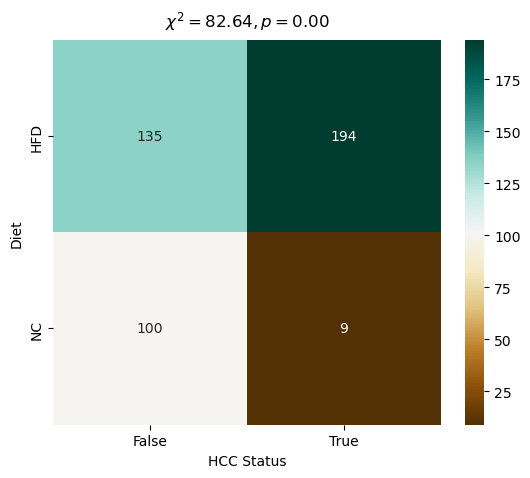

In [5]:
plt.figure(figsize=(6.25, 5))
crosstab = pd.crosstab(smd['diet'], smd['HCC'])
sns.heatmap(crosstab, annot = True, fmt='d', cmap = 'BrBG')
t, p, _, _ = stats.chi2_contingency(crosstab)
plt.text(
    0.5, 1.05,  # Relative placement in figure coordinates
    f'$\\chi^2 = {t:.2f}, p = {p:.2f}$',
    color='black',
    ha='center',
    va='center',
    transform=plt.gca().transAxes,  # Use Axes coordinates instead of data coordinates
    fontsize=12
)
plt.xlabel('HCC Status')
plt.ylabel('Diet')
plt.savefig('../results/figures/supp_hcc_diet.pdf', bbox_inches='tight')
plt.show()

## Run MetVAE

### Data pre-processing

In [6]:
# HCC samples
smd_hcc = smd[smd['HCC'] == True]
data_hcc = df_abundance.loc[:, smd_hcc.index].T
# Calculate the proportion of zeros in each column
proportion_zeros = (data_hcc == 0).mean()
data_hcc = data_hcc.loc[:, proportion_zeros <= 0.5]
n, d = data_hcc.shape

print('# HCC samples:', n)
print('# metabolites: ', d)
print('Proportion of zeros: ', np.round((data_hcc == 0).sum().sum()/data_hcc.size*100), '%')

# HCC samples: 203
# metabolites:  2084
Proportion of zeros:  5.0 %


In [7]:
# Non-HCC samples
smd_ctrl = smd[smd['HCC'] == False]
data_ctrl = df_abundance.loc[:, smd_ctrl.index].T
# Calculate the proportion of zeros in each column
proportion_zeros = (data_ctrl == 0).mean()
data_ctrl = data_ctrl.loc[:, proportion_zeros <= 0.5]
n, d = data_ctrl.shape

print('# Non-HCC samples:', n)
print('# metabolites: ', d)
print('Proportion of zeros: ', np.round((data_ctrl == 0).sum().sum()/data_ctrl.size*100), '%')

# Non-HCC samples: 235
# metabolites:  2085
Proportion of zeros:  4.0 %


In [8]:
# Subset to the overlapped features
overlap_features = list(set(data_hcc.columns).intersection(data_ctrl.columns))
overlap_features.sort()
data_hcc = data_hcc.loc[:, overlap_features]
data_ctrl = data_ctrl.loc[:, overlap_features]

data_hcc.to_csv('../results/intermediate_results/hcc/hcc_data_case.csv')
data_ctrl.to_csv('../results/intermediate_results/hcc/hcc_data_ctrl.csv')

print('After preprocessing:')
print('# HCC cases:', data_hcc.shape[0])
print('# Non-HCC controls:', data_ctrl.shape[0])
print('# metabolites:', len(overlap_features))
print('Proportion of zeros in HCC cases: ', np.round((data_hcc == 0).sum().sum()/data_hcc.size*100), '%')
print('Proportion of zeros in non-HCC controls: ', np.round((data_ctrl == 0).sum().sum()/data_ctrl.size*100), '%')

After preprocessing:
# HCC cases: 203
# Non-HCC controls: 235
# metabolites: 2084
Proportion of zeros in HCC cases:  5.0 %
Proportion of zeros in non-HCC controls:  4.0 %


In [9]:
fmd.loc[:, 'Smiles'].isna().value_counts(dropna=False)

Smiles
True     1954
False     168
Name: count, dtype: int64

### HCC samples

In [10]:
# torch.manual_seed(123)
# np.random.seed(123)

# max_epochs=1000
# learning_rate=1e-3

# model = MetVAE(data=data_hcc,
#                features_as_rows=False,
#                meta=smd_hcc,
#                categorical_covariate_keys=['diet'],
#                latent_dim = data_hcc.shape[0],
#                use_gpu=False)

# model.train(batch_size=100,
#             num_workers=0,
#             max_epochs=max_epochs,
#             learning_rate=learning_rate,
#             log_every_n_steps=1)

In [11]:
# df_loss = pd.DataFrame({
#     'Epoch': range(1, max_epochs+1),
#     'Training Loss': model.train_loss
# })
# # Get the initial loss
# init_loss = df_loss['Training Loss'].iloc[0]
# # Keep only rows where loss is less than or equal to initial loss to facilitate the visualization
# df_loss = df_loss[df_loss['Training Loss'] <= init_loss]

# window_size = 50
# df_loss['MA Training Loss'] = df_loss['Training Loss'].rolling(window=window_size).mean()
# df_loss.replace([np.inf, -np.inf], np.nan, inplace=True)

# plt.figure(figsize=(5, 4))
# sns.set_theme(style="whitegrid")   
# sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', markersize=4, color='blue', label='Original')
# sns.lineplot(data=df_loss, x='Epoch', y='MA Training Loss', color='red', label='Moving Avg')
# plt.show()

In [12]:
# model.get_corr(num_sim=1000)

In [13]:
# n, d = data_hcc.shape
# alpha_grid = np.array([0.5/(n*d)])

# random.seed(123)
# results_metvae = model.sparse_by_thresholding(th_len=100, n_cv=5, soft=False, n_jobs=10, alpha_grid=alpha_grid)
# est_cor_hcc = results_metvae['sparse_estimate']

# df_cor_hcc = pd.DataFrame(
#     est_cor_hcc,
#     index=data_hcc.columns,
#     columns=data_hcc.columns
# )
# df_cor_hcc.head()

### Non-HCC samples

In [14]:
# torch.manual_seed(123)
# np.random.seed(123)

# max_epochs=1000
# learning_rate=1e-3

# model = MetVAE(data=data_ctrl,
#                features_as_rows=False,
#                meta=smd_ctrl,
#                categorical_covariate_keys=['diet'],
#                latent_dim = data_ctrl.shape[0],
#                use_gpu=False)

# model.train(batch_size=100,
#             num_workers=0,
#             max_epochs=max_epochs,
#             learning_rate=learning_rate,
#             log_every_n_steps=1)

In [15]:
# df_loss = pd.DataFrame({
#     'Epoch': range(1, max_epochs+1),
#     'Training Loss': model.train_loss
# })
# # Get the initial loss
# init_loss = df_loss['Training Loss'].iloc[0]
# # Keep only rows where loss is less than or equal to initial loss to facilitate the visualization
# df_loss = df_loss[df_loss['Training Loss'] <= init_loss]

# window_size = 50
# df_loss['MA Training Loss'] = df_loss['Training Loss'].rolling(window=window_size).mean()
# df_loss.replace([np.inf, -np.inf], np.nan, inplace=True)

# plt.figure(figsize=(5, 4))
# sns.set_theme(style="whitegrid")   
# sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', markersize=4, color='blue', label='Original')
# sns.lineplot(data=df_loss, x='Epoch', y='MA Training Loss', color='red', label='Moving Avg')
# plt.show()

In [16]:
# model.get_corr(num_sim=1000)

In [17]:
# n, d = data_ctrl.shape
# alpha_grid = np.array([0.5/(n*d)])

# random.seed(123)
# results_metvae = model.sparse_by_thresholding(th_len=100, n_cv=5, soft=False, n_jobs=10, alpha_grid=alpha_grid)
# est_cor_ctrl = results_metvae['sparse_estimate']

# df_cor_ctrl = pd.DataFrame(
#     est_cor_ctrl,
#     index=data_ctrl.columns,
#     columns=data_ctrl.columns
# )
# df_cor_ctrl.head()

### Outputs

In [18]:
# output_file = '../results/outputs/hcc/hcc_corr.xlsx'
# with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#     df_cor_hcc.to_excel(writer, sheet_name='hcc', index=True)
#     df_cor_ctrl.to_excel(writer, sheet_name='ctrl', index=True)

### Visualization

In [19]:
df_cor_hcc = pd.read_excel('../results/outputs/hcc/hcc_corr.xlsx', sheet_name=0, index_col=0)
df_cor_hcc.index = df_cor_hcc.index.astype(str)
df_cor_hcc.columns = df_cor_hcc.columns.astype(str)

df_cor_ctrl = pd.read_excel('../results/outputs/hcc/hcc_corr.xlsx', sheet_name=1, index_col=0)
df_cor_ctrl.index = df_cor_hcc.index.astype(str)
df_cor_ctrl.columns = df_cor_hcc.columns.astype(str)

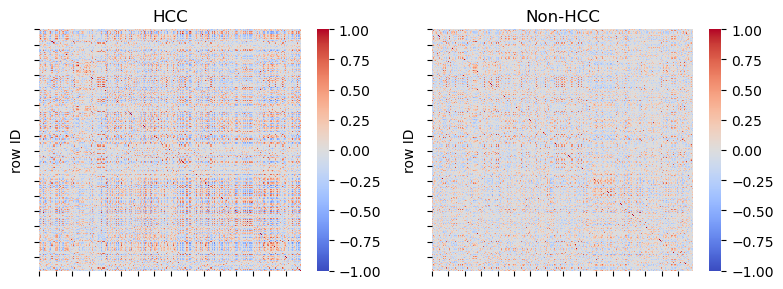

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the heatmaps with a shared color bar scale
sns.heatmap(df_cor_hcc, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, ax=axs[0])
axs[0].set_title('HCC')
axs[0].set_xticklabels([]) 
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

sns.heatmap(df_cor_ctrl, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, ax=axs[1])
axs[1].set_title('Non-HCC')
axs[1].set_xticklabels([]) 
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

plt.tight_layout()
plt.show()

## Compare the correlations and cosine similarities among HCC samples.

In [21]:
# Helper functions

def analyze_component_overlap(corr_edges, cosine_edges, connected_components):
    """
    Analyze the overlap of nodes between cosine similarity and positive correlation edges.
    
    Args:
    - corr_edges: Edges from correlation
    - cosine_edges: Edges from cosine similarity
    - connected_components: Connected components in the original graph
    
    Returns:
    - DataFrame with component overlap statistics
    """
    # Find common edges between cosine similarity and correlation
    common_edges = set(cosine_edges) & set(corr_edges)

    if not common_edges:
        print("Warning: There are no common edges")
        return None
    
    # Extract unique nodes from common edges
    sources, destinations = zip(*list(common_edges))
    common_nodes = set(sources) | set(destinations)
    
    # Dictionary to store overlap statistics for each component
    component_overlap_stats = {}
    
    # Analyze overlap for each connected component
    for component_idx, component_nodes in enumerate(connected_components):
        # Calculate number of nodes overlapping with common nodes
        overlapping_nodes_count = len(common_nodes & component_nodes)
        total_nodes_count = len(component_nodes)
        
        # Store overlap statistics
        component_overlap_stats[component_idx] = {
            'Overlapping Nodes': overlapping_nodes_count,
            'Total Nodes': total_nodes_count
        }
    
    # Convert results to a DataFrame and sort by overlapping nodes
    results = pd.DataFrame.from_dict(component_overlap_stats, orient='index')
    results = results.sort_values('Overlapping Nodes', ascending=False)
    
    return results

def analyze_component_disjoint(corr_edges, cosine_edges, connected_components):
    """
    Analyze intersections between connected components in a graph.
    
    Args:
    - corr_edges: Edges from correlation
    - cosine_edges: Edges from cosine similarity
    - connected_components: Connected components in the original graph
    
    Returns:
    - DataFrame with component intersection details
    """
    # Find edges that are in positive correlation but not in the original graph
    corr_only_edges = set(corr_edges) - set(cosine_edges)

    if not corr_only_edges:
        print("Warning: There are no unique edges")
        return None
    
    # Extract source and destination nodes from these unique edges
    sources, destinations = zip(*list(corr_only_edges))
    
    # Combine unique nodes from these special edges
    combined_nodes = set(sources + destinations)
    
    # Dictionary to store intersection results
    component_intersect_stats = {}
    
    # Iterate through pairs of connected components
    for i, component_i in enumerate(connected_components):
        for j, component_j in enumerate(connected_components):
            # Skip comparing a component with itself
            if i == j:
                continue
            
            # Combine the two components
            combined_component = component_i.union(component_j)
            
            # Calculate intersection with combined nodes and store details
            component_intersect_stats[(i, j)] = (len(combined_nodes & combined_component), i, len(component_i), j, len(component_j))
            
    results = pd.DataFrame(component_intersect_stats).T.sort_values(0, ascending=False)
    results = results.rename(
        columns={
            0 : 'intersection_size', 1: 'component_i_index', 2: 'graph_i_size', 
            3: 'component_j_index', 4: 'graph_j_size'})
    
    return results

In [22]:
# Load the graph
G = nx.read_graphml('../data/hcc/hcc_cosine_graph.graphml')
cosine_nodes = list(G.nodes)
cosine_edges = list(G.edges)

# Get all connected components from graph G
# A connected component is a subgraph where any two nodes are connected by a path
connected_components = list(nx.connected_components(G))

# Load the correlation edges
corr_edges = pd.melt(df_cor_hcc.reset_index(), id_vars='row ID', var_name = 'dest', value_name = 'r').rename(columns={'row ID': 'source'})
# Extract positive correlation edges
pos_corr_edges = corr_edges.query('r > 0.9 and source != dest')
pos_corr_edges = list(pos_corr_edges.apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).values)
# Extract negative correlation edges
neg_corr_edges = corr_edges.query('r < -0.7 and source != dest')
neg_corr_edges = list(neg_corr_edges.apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).values)

### Intersection between high positive correlation and cosine similarity

Our goal is to identify pairs of metabolites that exhibit both high positive correlations and strong structural similarities.

Subgraph 1304 exhibits the highest number of overlapping edges between correlation and cosine similarity.

In [23]:
pos_overlap = analyze_component_overlap(pos_corr_edges, cosine_edges, connected_components)
pos_overlap

,Overlapping Nodes,Total Nodes
1304,2,2
0,0,10
1751,0,1
1743,0,1
1744,0,1
...,...,...
875,0,1
876,0,2
877,0,4
878,0,1


### Intersection between disjoint components with high positive correlation

Our goal is to identify pairs of metabolites with high positive correlations but low structural similarities.

There appear to be many positive correlations among subgraphs 2, 13, 59, and 338.

In [24]:
pos_disjoint = analyze_component_disjoint(pos_corr_edges, cosine_edges, connected_components)
pos_disjoint

intersection_size  component_i_index  graph_i_size  \
338  2                    16                338            20   
2    338                  16                  2            91   
338  59                   14                338            20   
2    13                   14                  2            91   
338  13                   14                338            20   
...                      ...                ...           ...   
1022 2272                  0               1022             1   
     2271                  0               1022             1   
     2270                  0               1022             1   
     2269                  0               1022             1   
1311 0                     0               1311             2   

           component_j_index  graph_j_size  
338  2                     2            91  
2    338                 338            20  
338  59                   59            46  
2    13                   13            28  
338  13                   13            28  
...                      ...           ...  
1022 2272               2272             1  
     2271               2271             1  
     2270               2270             2  
     2269               2269             1  
1311 0                     0            10  

[6872262 rows x 5 columns]

### Intersection between high negative correlation and cosine similarity

Our goal is to identify pairs of metabolites that exhibit both high negative correlations and strong structural similarities.

In [25]:
neg_overlap = analyze_component_overlap(neg_corr_edges, cosine_edges, connected_components)
neg_overlap

### Intersection between disjoint components with high negative correlation

Our goal is to identify pairs of metabolites with high negative correlations but low structural similarities.

There appear to be a few strong negative correlations among subgraphs 5, 13, 46, 59, and 338.

In [26]:
neg_disjoint = analyze_component_disjoint(neg_corr_edges, cosine_edges, connected_components)
neg_disjoint

intersection_size  component_i_index  graph_i_size  \
59   5                    4                 59            46   
     198                  4                 59            46   
338  5                    4                338            20   
59   13                   4                 59            46   
198  338                  4                198            19   
...                     ...                ...           ...   
907  802                  0                907             1   
     801                  0                907             1   
     800                  0                907             1   
     799                  0                907             1   
1311 0                    0               1311             2   

          component_j_index  graph_j_size  
59   5                    5            63  
     198                198            19  
338  5                    5            63  
59   13                  13            28  
198  338                338            20  
...                     ...           ...  
907  802                802             1  
     801                801             1  
     800                800             2  
     799                799             3  
1311 0                    0            10  

[6872262 rows x 5 columns]

### Outputs

In [27]:
subgraph2 = pd.DataFrame(list(connected_components[2]), columns=['node_name'])
subgraph5 = pd.DataFrame(list(connected_components[5]), columns=['node_name'])
subgraph13 = pd.DataFrame(list(connected_components[13]), columns=['node_name'])
subgraph59 = pd.DataFrame(list(connected_components[59]), columns=['node_name'])
subgraph338 = pd.DataFrame(list(connected_components[338]), columns=['node_name'])

subgraph2['cluster'] = 2
subgraph5['cluster'] = 5
subgraph13['cluster'] = 13
subgraph59['cluster'] = 59
subgraph338['cluster'] = 338

df_subgraphs = pd.concat((subgraph2, subgraph5, subgraph13, subgraph59, subgraph338), axis=0)
df_subgraphs

,node_name,cluster
0,3815,2
1,3614,2
2,3668,2
3,3574,2
4,3585,2
...,...,...
15,347,338
16,265,338
17,72,338
18,362,338
